In [1]:
import numpy as onp
import pandas as pd
from itertools import product

import jax
import jaxlib
from jax import grad, jit, vmap
import jax.numpy as np
import jax.random as random
from jax.experimental import optimizers
from jax.ops import index, index_update

import probaflow

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
def softmax(u, scale=1, corr_factor=1):
    """ 
    Probability equation for multinomial logit. 
    
    Parameters:
    ------------
    u: array-like. Array containing the utiliy estimate for each alternative. 
    scale: (int, optional ) - Scaling factor for exp(scale * u). Default = 1 
    axis: (None or int or tuple of ints, optional) – Axis or axes over which the sum is taken. By default axis is None, and all elements are summed.

    Returns: 
    ----------
    (array) Probabilites for each alternative
    """
    exp_utility = np.exp(scale * u)
    sum_exp_utility = np.sum(exp_utility * corr_factor, keepdims=True)
    proba = exp_utility / sum_exp_utility
    return proba

def logsums(u, scale=1, axis=1, corr_factor=1):
    """ 
    Maximum expected utility 
    Parameters:
    ------------
    u: array-like. Array containing the unscaled utility estimate for each alternative. 
    scale: (int, optional ) - Scaling factor for exp(scale * u). Default = 1 
    axis: (None or int or tuple of ints, optional) – Axis or axes over which the sum is taken. By default axis is None, and all elements are summed.

    return: 
    -------
    Maximum expected utility of the nest
    """
    return (1 / scale) * np.log(np.sum(np.exp(scale * u) * corr_factor, axis=axis))

class large_mnl():
    """
    Differentiable approach for multinomial logit with large alternative set 
    """

    def __init__(self, model_object=None, coeffs=None, n_choosers=None, n_alts=None):
        self.weights = coeffs
        self.n_choosers = n_choosers
        self.n_alts = n_alts
        # self.constrains  = constrains 
        ## TO DO: yaml file
            
    def utilities(self, x):
        """ Calculates the utility fuction of weights w and data x 
        Parameters:
        ------------
        x = Jax 2d array, OrcaTable wrapper name, Pandas DataFrame. Column names must match coefficient names.
            if a Jax array, order of columns should be the same order as the coeffient names. 

        Return:
        ------------
        2-d jax numpy array with utilities for eahc alternative.
        """

        w = self.weights
        n = self.n_choosers
        j = self.n_alts
        return np.dot(x, w.T).reshape(n,j)

    def probabilities(self, x, scale=1, corr_factor=1):
        ''' Estimates the probabilities for each alternative in the choice set for each individual '''
        utils = self.utilities(x)
        return vmap(softmax, in_axes=(0,None,None))(utils, scale, corr_factor)

    def logsum(self, x):
        ''' Estimates the maximum expected utility for all alternatives in the choice set
            Scale parameter normalized to 1. 
        '''
        utils = self.utilities(x)
        return vmap(logsums)(utils)

    def simulation(self, x, key):
        ''' 
        Monte Carlo simulation. 
        
        Parameters
        ----------
        x: 2-d Jax numpy array
        key: jax PRNG Key object
        
        Return
        -------
        - numpy.array 

        '''
        utils = self.utilities(x)
        shape = utils.shape
        keys = random.split(key, shape[0])

        @jit
        def single_simulation(u, key):
            return random.categorical(key, u)

        choices = vmap(single_simulation, in_axes=(0, 0))(utils, keys)
        return choices  ### Assuming alternative name starts at 0

In [5]:
def get_mct(choosers, alts, var_mats, chooser_alts=None):
    
    n_choosers = len(choosers)
    
    if chooser_alts is None:
        mct = np.concatenate(
            [np.concatenate([var_mats[v][c.home_zone, :].reshape(-1, 1) for i, c in choosers.iterrows()], axis=0)
            for v in range(len(var_mats))], axis=1)
    
    else:
        mct = np.concatenate(
            [np.concatenate([var_mats[v][c.home_zone, chooser_alts[i, :]].reshape(-1, 1) for i, c in choosers.iterrows()], axis=0)
            for v in range(len(var_list))], axis=1)
    
    return mct

# Simulate data 

#### Choosers

In [6]:
n_choosers = 10000
persons = pd.DataFrame({
    'id': range(n_choosers), 
    'home_zone': onp.random.randint(0, 200, n_choosers)})

#### Alternatives (zones)

In [7]:
num_alts = 1451
zones = np.array(range(num_alts))

#### Data and coefficients

In [8]:
var_list = ['var1', 'var2', 'var3', 'var4']  # i.e. travel time, distance, hhinc diff, etc
num_vars = len(var_list)
coeffs = np.array([1, -1, -2, 3])

#### OD skims

In [9]:
skims = np.column_stack((np.repeat(zones, num_alts), np.tile(zones, num_alts)))
size_long = skims.shape[0]
skim_mats = []
for var in var_list:
    skim_mats.append(onp.random.uniform(0, 5, size_long).reshape(num_alts, num_alts))

# Simulate choices -- no sampling

In [10]:
model = large_mnl(coeffs=coeffs, n_choosers=n_choosers, n_alts=num_alts)

In [11]:
%%time
mct = get_mct(persons, zones, skim_mats)

CPU times: user 10.2 s, sys: 2.27 s, total: 12.5 s
Wall time: 7.92 s


In [12]:
%%time
probs_true = model.probabilities(mct)

CPU times: user 192 ms, sys: 7.71 ms, total: 200 ms
Wall time: 577 ms


CPU times: user 6min 13s, sys: 942 ms, total: 6min 14s
Wall time: 6min 14s


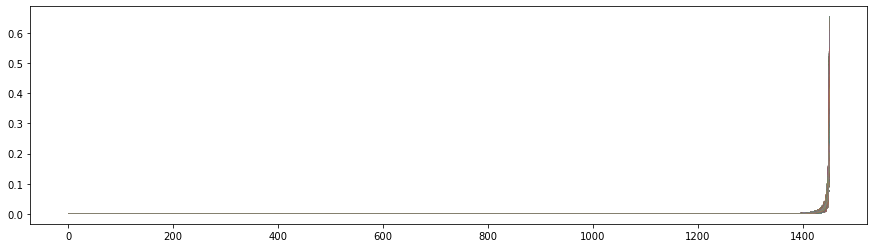

In [13]:
%%time
fig, ax = plt.subplots(figsize=(15, 4))
for row in probs_true.sort(axis=1):
    sns.lineplot(x=range(len(row)), y=row, ax=ax, lw=0.1)

<AxesSubplot:ylabel='Density'>

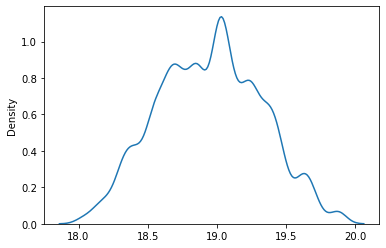

In [14]:
sns.kdeplot(logsums(model.utilities(mct)))

# With sampling

In [13]:
sample_size = 100
chooser_alts = onp.random.choice(
    zones, size=sample_size*n_choosers, replace=True).reshape((n_choosers, sample_size))

In [14]:
%%time
mct_sampled = get_mct(persons, zones, skim_mats, chooser_alts)
model = large_mnl(coeffs=coeffs, n_choosers=n_choosers, n_alts=sample_size)
probs_samp = model.probabilities(mct_sampled)

CPU times: user 9.9 s, sys: 2.18 s, total: 12.1 s
Wall time: 7.93 s


CPU times: user 3min 33s, sys: 577 ms, total: 3min 33s
Wall time: 3min 33s


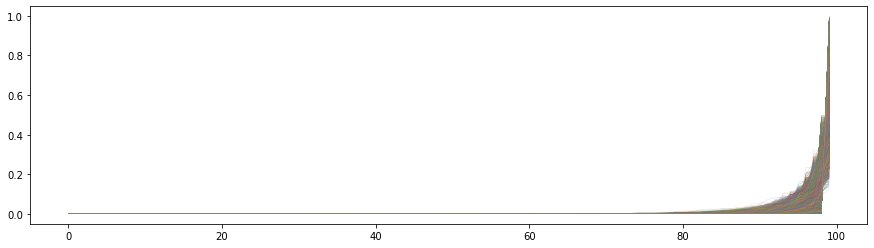

In [22]:
%%time
fig, ax = plt.subplots(figsize=(15, 4))
for row in probs_samp.sort(axis=1):
    sns.lineplot(x=range(len(row)), y=row, ax=ax, lw=0.1)

<AxesSubplot:ylabel='Density'>

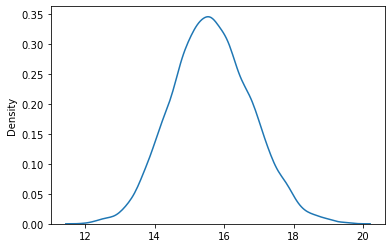

In [18]:
sns.kdeplot(logsums(model.utilities(mct_sampled)))

# Sampling with correction factor

In [15]:
sample_rate = sample_size / num_alts
corr_fac = 1 / sample_rate

In [16]:
probs_samp_corr = model.probabilities(mct_sampled, corr_factor=corr_fac)

CPU times: user 3min 33s, sys: 11.8 ms, total: 3min 33s
Wall time: 3min 33s


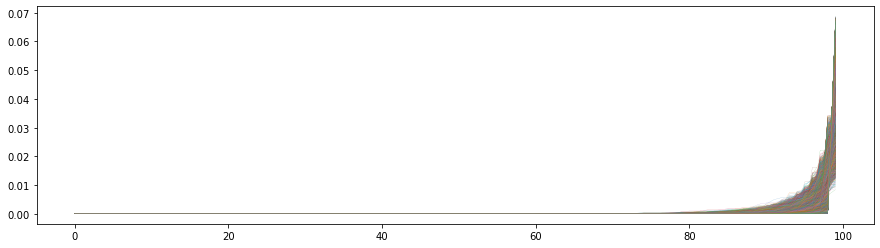

In [23]:
%%time
fig, ax = plt.subplots(figsize=(15, 4))
for row in probs_samp_corr.sort(axis=1):
    sns.lineplot(x=range(len(row)), y=row, ax=ax, lw=0.1)

# Comparison 

In [33]:
probs_true_sampled_rows = []
for i in range(len(chooser_alts)):
    chooser_alts_row = chooser_alts[i, :]
    probs_true_sampled_rows.append(probs_true[i, chooser_alts_row])

In [55]:
probs_true_sampled = np.concatenate([row for row in probs_true_sampled_rows]).reshape(n_choosers, sample_size)

In [101]:
probs_samp

DeviceArray([[3.4138409e-07, 4.0819682e-03, 7.2692201e-05, ...,
              1.1070144e-07, 9.9618237e-06, 2.1069107e-05],
             [8.6781506e-07, 9.2334085e-06, 1.0449475e-06, ...,
              8.2413579e-05, 3.8860957e-08, 5.8557657e-08],
             [2.1329038e-08, 3.9652446e-07, 2.7210252e-05, ...,
              3.5553141e-03, 2.1329038e-08, 6.2475671e-08],
             ...,
             [2.1820308e-09, 1.7756182e-08, 1.1626309e-09, ...,
              3.1534584e-09, 4.7414787e-07, 6.1518224e-10],
             [2.7869789e-06, 1.3623016e-06, 1.1284283e-06, ...,
              2.7290500e-06, 7.1042003e-08, 7.5371968e-06],
             [1.0101751e-10, 1.3518171e-09, 4.7823538e-05, ...,
              2.4717829e-07, 3.7146025e-04, 4.9027371e-10]],            dtype=float32)

In [106]:
probs_samp * np.log(1 / sample_rate)

DeviceArray([[9.1314718e-07, 1.0918604e-02, 1.9443987e-04, ...,
              2.9610842e-07, 2.6646265e-05, 5.6356450e-05],
             [2.3212647e-06, 2.4697873e-05, 2.7950653e-06, ...,
              2.2044298e-04, 1.0394677e-07, 1.5663225e-07],
             [5.7051722e-08, 1.0606387e-06, 7.2783019e-05, ...,
              9.5098894e-03, 5.7051722e-08, 1.6711230e-07],
             ...,
             [5.8365788e-09, 4.7494911e-08, 3.1098493e-09, ...,
              8.4349905e-09, 1.2682688e-06, 1.6455128e-09],
             [7.4547174e-06, 3.6439362e-06, 3.0183628e-06, ...,
              7.2997668e-06, 1.9002586e-07, 2.0160780e-05],
             [2.7020547e-10, 3.6158918e-09, 1.2792023e-04, ...,
              6.6116189e-07, 9.9359604e-04, 1.3114028e-09]],            dtype=float32)

In [102]:
probs_samp_corr

DeviceArray([[2.3527507e-08, 2.8132106e-04, 5.0098010e-06, ...,
              7.6293212e-09, 6.8654896e-07, 1.4520407e-06],
             [5.9808059e-08, 6.3634786e-07, 7.2015673e-08, ...,
              5.6797776e-06, 2.6782188e-09, 4.0356758e-09],
             [1.4699545e-09, 2.7327669e-08, 1.8752760e-06, ...,
              2.4502512e-04, 1.4699545e-09, 4.3056976e-09],
             ...,
             [1.5038115e-10, 1.2237202e-09, 8.0126177e-11, ...,
              2.1733000e-10, 3.2677313e-08, 4.2397121e-11],
             [1.9207297e-07, 9.3887088e-08, 7.7769002e-08, ...,
              1.8808062e-07, 4.8960720e-09, 5.1944841e-07],
             [6.9619232e-12, 9.3164511e-11, 3.2959019e-06, ...,
              1.7035029e-08, 2.5600293e-05, 3.3788677e-11]],            dtype=float32)

## Mean Probability Error Across Chooser 

#### Uncorrected

<AxesSubplot:ylabel='Density'>

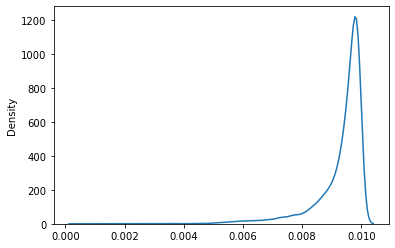

In [87]:
diff_no_corr = onp.abs(probs_true_sampled - probs_samp)
avg_diff_no_corr = diff_no_corr.mean(axis=1)
sns.kdeplot(avg_diff_no_corr.flatten())

#### With correction factor

<AxesSubplot:ylabel='Density'>

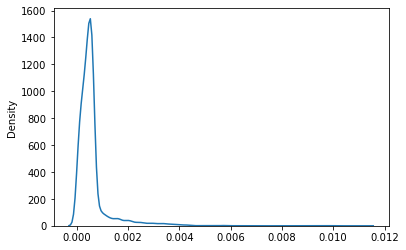

In [88]:
diff = onp.abs(probs_true_sampled - probs_samp_corr)
avg_diff = diff.mean(axis=1)
sns.kdeplot(avg_diff.flatten())

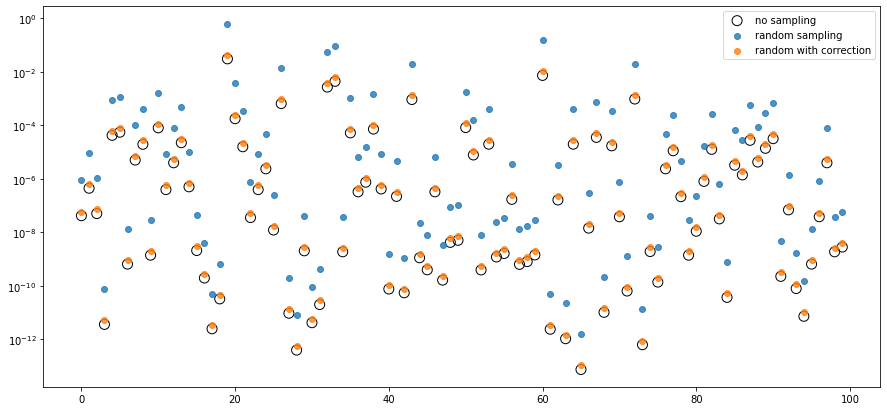

In [100]:
fig, ax = plt.subplots(figsize=(15,7))
person_id = 1
plt.scatter(
    x=range(sample_size), y=probs_true[person_id, chooser_alts[person_id, :]],
    s=100, marker='o',facecolor='none', edgecolor='k', label='no sampling')
plt.scatter(x=range(sample_size), y=probs_samp[person_id], alpha=0.8, label='random sampling')
plt.scatter(x=range(sample_size), y=probs_samp_corr[person_id], alpha=0.8, label='random with correction')
ax.set_yscale('log')
ax.legend()

In [81]:
onp.argmax(avg_diff)

6801

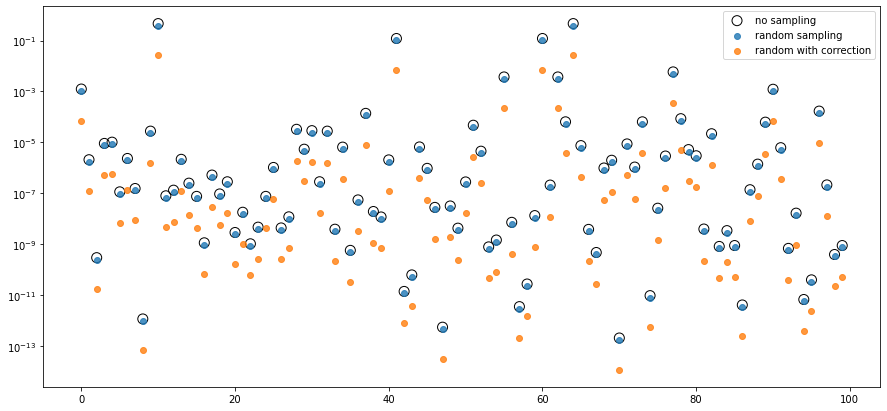

In [82]:
fig, ax = plt.subplots(figsize=(15,7))
person_id = 6801
plt.scatter(
    x=range(sample_size), y=probs_true[person_id, chooser_alts[person_id, :]],
    s=100, marker='o',facecolor='none', edgecolor='k', label='no sampling')
plt.scatter(x=range(sample_size), y=probs_samp[person_id], alpha=0.8, label='random sampling')
plt.scatter(x=range(sample_size), y=probs_samp_corr[person_id], alpha=0.8, label='random with correction')
ax.set_yscale('log')
ax.legend()